# Training model for pneumothorax segmentation task
- ## Segmentation ( Part 2 )

- Build on `tensorflow 1.13.1`
- `Keras 2.2.4` 

In [1]:
import tensorflow as tf
from data_pipeline import *
from model_metrics import *
from model_utils import *
from deeplab_model import *
import glob as glob
import keras
import seaborn as sns

# Configure GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess=tf.Session(config = config)

Using TensorFlow backend.


### Import csv file labels and image name (Stage 1 data)

In [2]:
# loading given data
csv_root = os.path.join(root_dir, 'train/train-rle.csv')
train_csv = pd.read_csv(csv_root)

# some checks on distribution of data
non_pneu_cases = train_csv['ImageId'][train_csv[' EncodedPixels'].values == ' -1']
non_pneu = sum((train_csv[' EncodedPixels'].values == ' -1').astype(np.int8))

print('------- Distribution of raw dataset ----------------')
print('Number of non pneumothorax cases: ', non_pneu)
print('Number of pneumothorax cases that may contain multiple entry masks: ',
      len(train_csv.ImageId)-non_pneu)

# more checks on unique distribution
pneu_cases = train_csv.ImageId.values[(train_csv[' EncodedPixels'].values != ' -1')]
pneu_imgs = collections.Counter(pneu_cases)

print('------- Distribution of unique identity ----------------')
print('Number of pneumothorax unique cases: ',len(pneu_imgs.keys()))
print('Proportion of positive cases: ',
      len(pneu_imgs.keys())/ (len(pneu_imgs.keys())+ non_pneu))

------- Distribution of raw dataset ----------------
Number of non pneumothorax cases:  8296
Number of pneumothorax cases that may contain multiple entry masks:  3286
------- Distribution of unique identity ----------------
Number of pneumothorax unique cases:  2379
Proportion of positive cases:  0.22285714285714286


### From Data pipeline, we split our dataset into 0.8:0.2 

In [3]:
# data splitting
imgName_train = [i.split('/')[-1] for i in imgs_train]
imgName_valid = [i.split('/')[-1] for i in imgs_valid]
nontypeName = [i + '.png' for i in non_pneu_cases]

positive_train = len(set(imgName_train) - set(nontypeName))
positive_valid = len(set(imgName_valid) - set(nontypeName))

print('------- Distribution of split data ----------------')
print('Training images size: ', len(imgs_train))
print('Proportion of positive cases (Train): ', positive_train/len(imgs_train))
print('Validation images size: ', len(imgs_valid))
print('Proportion of positive cases (Validation): ', positive_valid/len(imgs_valid))

------- Distribution of split data ----------------
Training images size:  9637
Proportion of positive cases (Train):  0.3110926636920203
Validation images size:  2410
Proportion of positive cases (Validation):  0.312448132780083


### Percentage of segmented pneumothorax area in a mask

In [4]:
all_mask_fn = glob.glob('./train/images/1024/mask/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(plt.imread(fn)).sum()/(1024*1024) 

mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

/home/dianwen/.virtualenvs/3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Density plot of mask percentage')

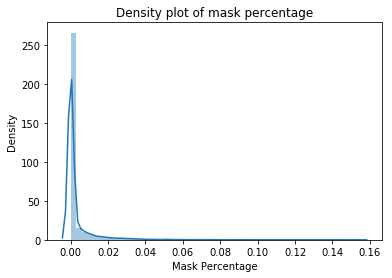

In [5]:
# plot density plot  
ax = sns.distplot(mask_df.mask_percentage)
ax.set_ylabel('Density')
ax.set_xlabel('Mask Percentage')
ax.set_title('Density plot of mask percentage')

# Build Keras model

In our strategy, we trained 4 models to predict the segmentation probability map of the pneumothorax case <br>
Additionally, we exploit the discussion posted by Dr. Konya given 1000 hand drawn bounding boxes to train a faster RCNN to quickly learn the bounding boxes of the rest. <br>
We hypothesize that cropping more regional/focused image increases the resolution of the input and model can learn better.

- Our segmentation model are namely as follows:
>1. Efficient U-net plus plus (with bounding boxes)
>2. Efficient U-net (with bounding boxes)
>3. Xception U-net plus plus (with bounding boxes)
>4. Efficient U-net plus plus (without)


## Build data generator
- we train our model with generator defined here

In [2]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop, Normalize
)

h, w, batch_size = 512, 512, 16
# Augmentation configs
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightness(p=0.3),
    OneOf([
        RandomContrast(limit=0.5),
        CLAHE(clip_limit=2.)
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=100 * 0.16, alpha_affine=100 * 0.04),
        GridDistortion(),
        OpticalDistortion(distort_limit=1.0, shift_limit=0.05),
        ], p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

### Visualizing data generator

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

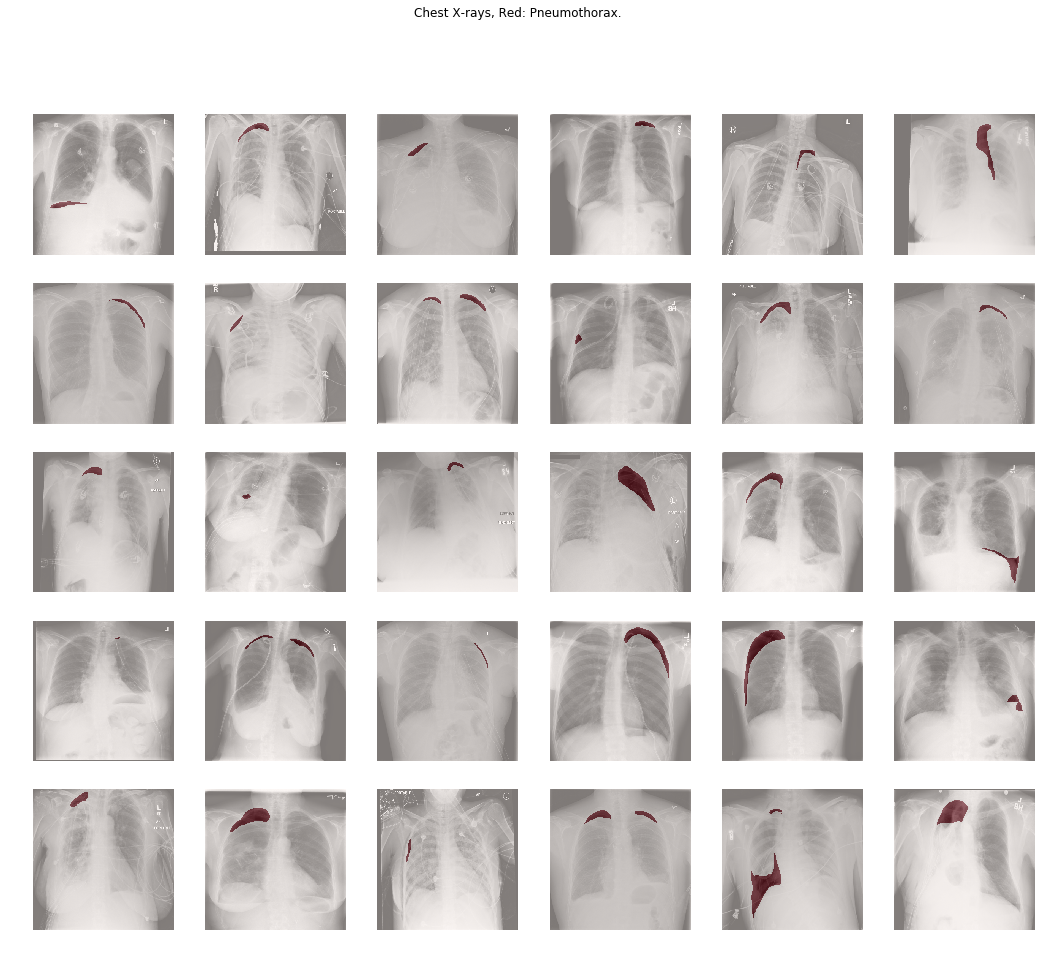

In [3]:
a = DataGenerator(pos_img, pos_mask, augmentations=None, 
                  batch_size=30, img_size=512, n_channels=3, 
                  shuffle=False, by_ratio=False,
                  num_ensemble=False, box_cropping = False)

images,masks = a.__getitem__(0)
max_images = 30
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

### Visualising data augmentation

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

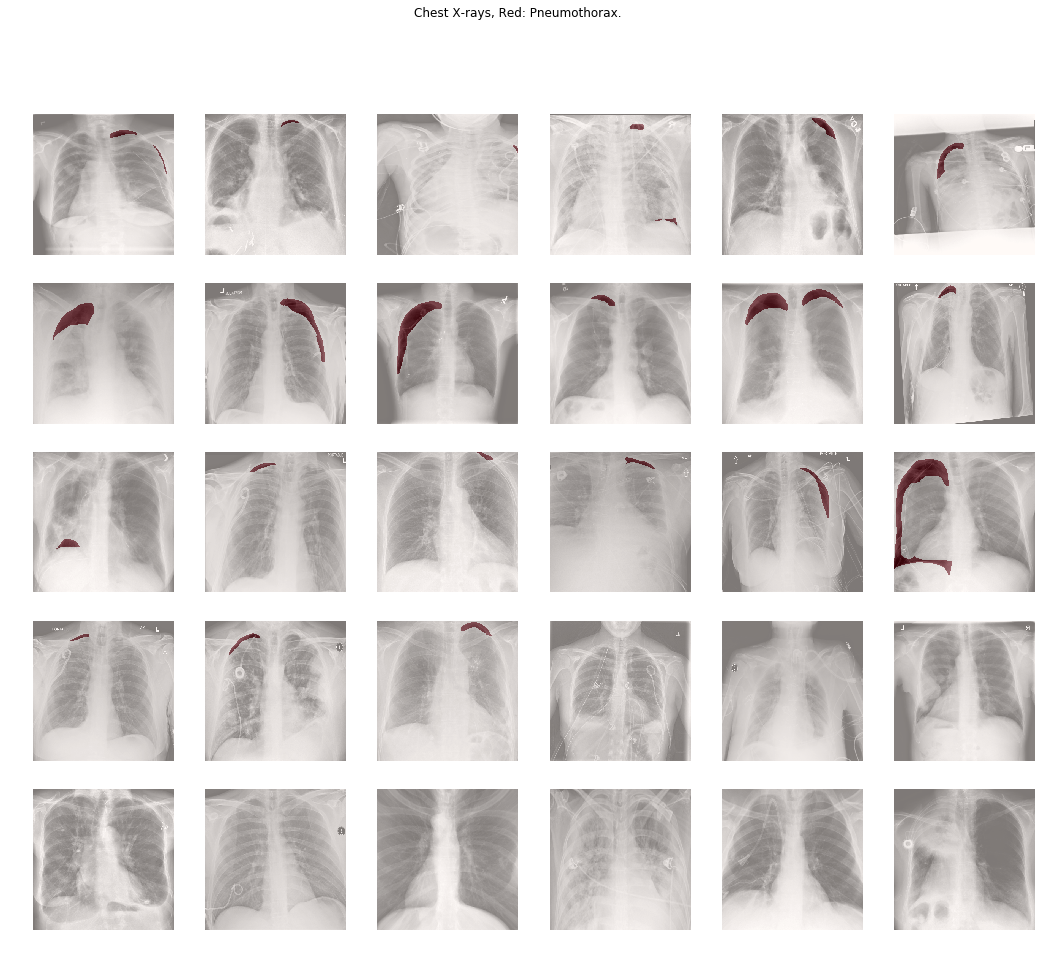

In [4]:
train_im_path = [list(pos_img).copy(), list(neg_img).copy()]
train_mask_path = [list(pos_mask).copy(), list(neg_mask).copy()]


a = DataGenerator(train_im_path, train_mask_path, augmentations=AUGMENTATIONS_TRAIN, 
                  batch_size=30, img_size=512, n_channels=3, 
                  shuffle=True, by_ratio=0.7,
                  num_ensemble=False, box_cropping = True)
    

images,masks = a.__getitem__(312)
max_images = 30
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="gray")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

> Here we assign our generator for training.
> - training generator takes oversampling algorithm with ratio given 70% positive (with croppings)
> - validation generator takes only positive generator to assess how good our model is detecting for the positive/negative cases

In [5]:
# make augmentation generator
train_generator = DataGenerator(train_im_path, train_mask_path, augmentations=AUGMENTATIONS_TRAIN,
                                batch_size=batch_size, img_size=w, shuffle=True, by_ratio=0.7,
                                num_ensemble=False, box_cropping = True)             
valid_generator = DataGenerator(stratified_valid_im, stratified_valid_lab, augmentations=AUGMENTATIONS_TEST, 
                                batch_size=batch_size, img_size=w, shuffle=True, by_ratio=False,
                                num_ensemble=False, box_cropping = False)

# Build Model

In [6]:
from models import *
from models.basics_functions import ModelMGPU
from models.efficient_unet import UEfficientNet
from models.efficient_upp import UEfficientNetpp
from models.xception_upp import XceptionNet

# Define configs
num_classes = 1
epochs = 40
init_lr = 3e-4

# Model Metrics
metrics = ['dice_score',
           'iou',
           'pixelwise_sensitivity',
           'pixelwise_specificity']

# define loss
loss = 'bce_dice'

# define models
keras.backend.clear_session()

# model 1
model_efficient = UEfficientNet(input_shape=(512,512,3), dropout_rate=0.50)
# model_efficient.load_weights('./saved_weights/model_efficient.hdf5')

# model 2
model_effipp = UEfficientNetpp(input_shape=(512,512,3), dropout_rate=0.50)
# model_effipp.load_weights('./saved_weights/model_efficientpp_nocrop.hdf5')

# model 3
model_effipp_crop = UEfficientNetpp(input_shape=(512,512,3), dropout_rate=0.50)
# model_effipp_crop.load_weights('./saved_weights/model_efficientpp_cropped.hdf5')

# model 4
model_xception = XceptionNet(input_shape=(512,512,3), dropout_rate=0.50)
# model_xception.load_weights('./saved_weights/model_xceptionpp.hdf5')


# define callbacks
callbacks = SnapshotCallbackBuilder(nb_epochs=epochs, 
                                    nb_snapshots=1,
                                    init_lr=init_lr)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Run the next two cell to train individual models and visual inspect on model performance

In [ ]:
# RUN THIS TO DO INDIVIDUAL TRAINING.
model_efficient = ModelMGPU(model_efficient, 4) # change model name for selected models (model_efficient, model_effipp, model_effipp_crop, model_xception)

# compile model
compile_model(model_efficient, num_classes, metrics, loss, init_lr)

# Fit models
train_with_generator(model=model_efficient, epochs=epochs, train_generator=train_generator,
                     valid_generator= valid_generator, callbacks= callbacks.get_callbacks(), mp = False)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Epoch 1/40


### Visualisation of model performance

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

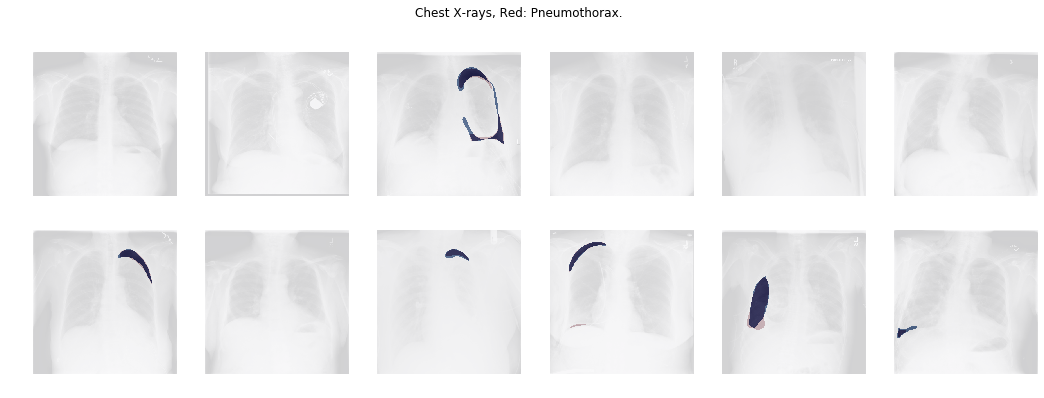

In [10]:
pred_images, target_masks = valid_generator.__getitem__(0)
pred_mask = model_efficient.predict(pred_images)
max_images = 12
grid_width = 6
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3., grid_height*3.))

for i in range(max_images):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(pred_images[i])
    pred_mask_ = (pred_mask[i].squeeze() > 0.5).astype(int)
    ax.imshow(pred_mask_, cmap='Reds',alpha=0.6)
    ax.imshow(target_masks[i].squeeze(), cmap='Blues', alpha = 0.6)    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

## Ensembling our segmentation models
We have trained our models and the weights are saved in the folder.
- import weights to our models to implement ensembling.

In [7]:
# load weights
# model 1
model_efficient.load_weights('./saved_weights/segmentation/model_efficient.hdf5')
# model 2
model_effipp.load_weights('./saved_weights/segmentation/model_efficientpp_nocrop.hdf5')
# model 3
model_effipp_crop.load_weights('./saved_weights/segmentation/model_efficientpp_cropped.hdf5')
# model 4
model_xception.load_weights('./saved_weights/segmentation/model_xceptionpp.hdf5')

candidates = [model_efficient, model_effipp, model_effipp_crop, model_xception]

In [13]:
from keras.layers.merge import concatenate
from keras.layers import Input, Conv2D
from keras.models import Model

# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    
    img_input = Input((512,512,3))
    
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    ensemble_visible.append(img_input)
    
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    ensemble_outputs.append(img_input)
    merge = concatenate(ensemble_outputs)
    
    # version 1
    conv_init = Conv2D(32,3,activation='relu',padding='same')(merge)
    conv_init = Conv2D(32,3,activation='relu',padding='same')(conv_init)
    
    conv0 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    
    conv1 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    
    conv2 = Conv2D(32, 1, activation='relu', padding='same')(conv_init)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    
    conv = concatenate([conv0,conv1,conv2])
    conv = Conv2D(32, 1, activation='relu', padding='same')(conv)
    conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
    conv = Conv2D(32, 3, activation='relu', padding='same')(conv)

#     # version 2
#     conv = Conv2D(32, 1, activation='relu', padding='same')(merge)
#     conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
#     conv = Conv2D(32, 3, activation='relu', padding='same')(conv)
    
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(conv) 
    model = Model(inputs=ensemble_visible, outputs=output)

    return model

stacked_model = define_stacked_model(candidates)
compile_model(stacked_model, num_classes, metrics, loss, init_lr)
stacked_model = ModelMGPU(stacked_model, 4)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [ ]:
compile_model(stacked_model, num_classes, metrics, loss, init_lr)

# training our stack model
num_models = 4
batch_size = 32
train_stackgenerator = DataGenerator(train_im_path, train_mask_path, augmentations=AUGMENTATIONS_TRAIN,
                                     batch_size=batch_size, img_size=w, shuffle=True, by_ratio=0.7,
                                     num_ensemble=num_models, box_cropping = True)  

valid_stackgenerator = DataGenerator(stratified_valid_im, stratified_valid_lab, augmentations=AUGMENTATIONS_TEST, 
                                     batch_size=batch_size, img_size=w, shuffle=True, by_ratio=False,
                                     num_ensemble=num_models, box_cropping=False)

train_with_generator(model=stacked_model, epochs=epochs, train_generator=train_stackgenerator,
                     valid_generator= valid_stackgenerator, callbacks= callbacks.get_callbacks(), mp = False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


/data/volume03/SIIM_ACR/data_pipeline.py:281: RuntimeWarning: invalid value encountered in greater
  y[y>0] = 255


 79/586 [===>..........................] - ETA: 29:32 - loss: 0.7108 - binary_dice_coeff: 0.5320 - my_iou_metric: 0.4069 - binary_pixelwise_sensitivity: 0.3827 - binary_pixelwise_specificity: 0.8889

### Load Models and visualisation
- Alternative to training from scratch, stack model weights are given for loading

In [20]:
stacked_model.load_weights('./saved_weights/stacked_model.hdf5')

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

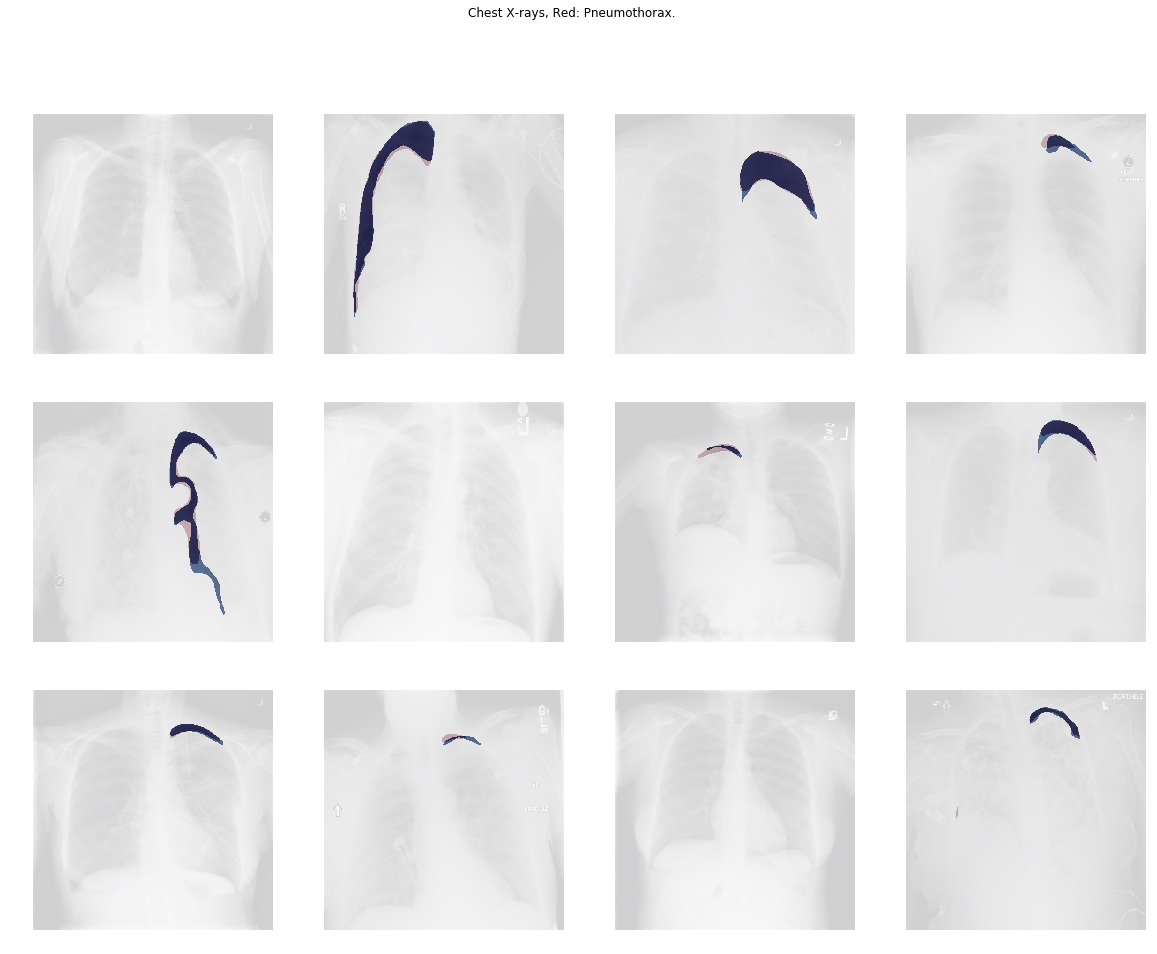

In [14]:
pred_images, target_masks = valid_stackgenerator.__getitem__(5)
pred_mask = stacked_model.predict(pred_images)
max_images = 12
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5., grid_height*5.))

for i in range(max_images):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(pred_images[0][i])
    pred_mask_ = (pred_mask[i].squeeze() > 0.5).astype(int)
    ax.imshow(pred_mask_, cmap='Reds',alpha=0.6)
    ax.imshow(target_masks[i].squeeze(), cmap='Blues', alpha = 0.6)    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

### Validation of model performance

In [18]:
# define prediction function
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    truth, pred = np.empty((0,512,512)), np.empty((0,512,512))
    for i in range(len(valid_generator)):
        pred_images, target_masks = validation_generator.__getitem__(i)
        target_masks = target_masks.reshape(-1,img_size,img_size)
        preds_test1 = model.predict(pred_images).reshape(-1, img_size, img_size)
        truth = np.append(truth, target_masks, axis = 0)
        pred = np.append(pred, preds_test1, axis = 0)
    return truth, pred

In [19]:
# generate prediction results
target_masks, preds_valid = predict_result(stacked_model, valid_stackgenerator,512)

In [20]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [21]:
## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 30)
ious = np.array([iou_metric_batch(target_masks, np.int32(preds_valid > threshold)) for threshold in thresholds])

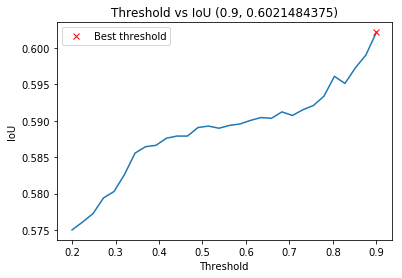

In [22]:
# Plot IoU v.s. threshold to assess imbalance 
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Generate testing predictions

In [ ]:
from glob import glob
test_fn = glob('./stage2/*')
x_test = [cv2.resize(np.array(plt.imread(fn)),(512,512)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)

preds_test = np.empty((0,512,512,1))
for i, im in enumerate(x_test):
    imtest = [np.expand_dims(im,axis=0) for _ in range(len(stacked_model.input))]
    # prediction with stacked model
    preds_mask = stacked_model.predict(imtest)
    preds_test = np.append(preds_test, preds_mask, axis=0)
# # del x_test; gc.collect()

(3205, 512, 512, 3)


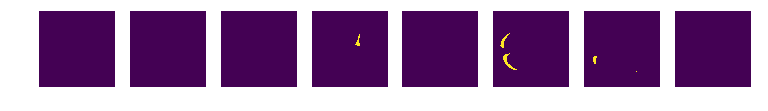

In [31]:
from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in preds_test:
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [32]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,ID_36ee4f448,-1
1,ID_cafbf4ffb,-1
2,ID_7dd6c9d4c,-1
3,ID_f6044c733,317059 4 1018 7 1016 8 1015 9 1015 9 1014 10 1...
4,ID_609806ebc,-1


In [33]:
sub_df.to_csv('stack_seg_ver2.csv', index=False)
sub_df.tail(10)

,ImageId,EncodedPixels
3195,ID_b0e96ee4c,336111 3 1019 6 1016 8 1014 9 1013 11 1011 13 ...
3196,ID_6243413f3,-1
3197,ID_86242dc04,-1
3198,ID_6079d5845,-1
3199,ID_3ece7031b,-1
3200,ID_2892d816e,365849 6 1015 9 1012 12 1009 14 1008 16 1005 1...
3201,ID_7b32caa67,-1
3202,ID_adca2580b,-1
3203,ID_6b8fe08ab,-1
3204,ID_a2e7da171,-1


### Post processing with correcting negative classes with classification results

In [34]:
sub_df = pd.read_csv('stack_seg_ver2.csv')
pred_class = pd.read_csv('./stackclass_label2.csv')
pred_class['ImageId'] = [splitext(name)[0] for name in pred_class.image]
sub_df = sub_df.merge(pred_class, on='ImageId')
sub_df['Class_pred'] = [i == 0 for i in sub_df.label]
sub_df['EncodedPixels'] = np.where(sub_df.Class_pred,'-1',sub_df.EncodedPixels)
sub_df.to_csv('stack_seg_final_ver3.csv',columns=['ImageId','EncodedPixels'],index=False)

In [35]:
sub_df.head()

,ImageId,EncodedPixels,image,class_prob,label,Class_pred
0,ID_36ee4f448,-1,ID_36ee4f448.png,0.023437,0,True
1,ID_cafbf4ffb,-1,ID_cafbf4ffb.png,0.027966,0,True
2,ID_7dd6c9d4c,-1,ID_7dd6c9d4c.png,0.102540,0,True
3,ID_f6044c733,317059 4 1018 7 1016 8 1015 9 1015 9 1014 10 1...,ID_f6044c733.png,0.939917,1,False
4,ID_609806ebc,-1,ID_609806ebc.png,0.023497,0,True
